# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [ ]:
# Enter your information here
first_and_last_name = 'Emadeddin'
std_number = '403206479'

![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [1]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader


Check your device. We recommend using GPU. You can use GPU with google colab.

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [3]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0)

    # Normalize the input
    x_normalized = (x - mean) / np.sqrt(variance + epsilon)

    # Scale and shift
    output = gamma * x_normalized + beta

    return output

In [4]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [5]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])




# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# TODO: create train data loader without shuffle with just half of the data
train_indices = list(range(len(train_set) // 2))
train_subset = Subset(train_set, train_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=False, num_workers=2)

# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# TODO: create test
test_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 49120880.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Explain what we did in transfor train and tranform test:<br/>
*In transform_train, we applied data augmentation techniques such as RandomResizedCrop to randomly crop the image to 224x224 with varying scales, and RandomHorizontalFlip to introduce variations in orientation. These augmentations help the model generalize better by simulating diverse scenarios. The data is then converted to tensors and normalized using the specified mean and standard deviation values. In transform_test, we only resized the images to a fixed 224x224 size and normalized them, ensuring consistency during evaluation without introducing variability. This distinction ensures robust training and reliable testing.*

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

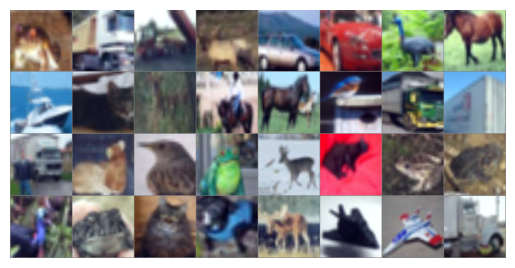

Labels: [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6 4 3 6 6 2 6 3 5 4 0 0 9]


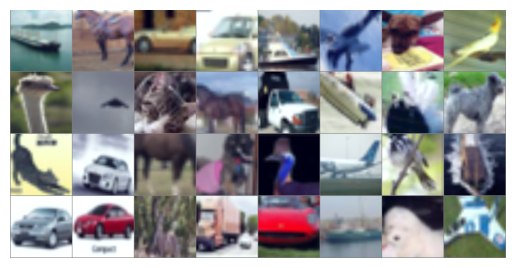

Augmented Labels: [8 7 1 1 8 0 5 2 2 0 3 7 9 8 2 5 3 1 7 5 2 0 2 8 1 1 4 9 1 8 5 0]


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img, labels=None, classes=None):
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img * 0.2675 + 0.5071, 0, 1)
    plt.imshow(img)
    plt.axis("off")
    if labels is not None and classes is not None:
        title = ' '.join(classes[labels[i]] for i in range(len(labels)))
        plt.title(title)
    plt.show()

train_loader_shuffle_false = DataLoader(train_subset, batch_size=32, shuffle=False, num_workers=2)

data_iter = iter(train_loader_shuffle_false)
images, labels = next(data_iter)
imshow(torchvision.utils.make_grid(images, nrow=8))
print("Labels:", labels.numpy())

train_loader_shuffle_true = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

data_iter_augmented = iter(train_loader_shuffle_true)
augmented_images, augmented_labels = next(data_iter_augmented)
imshow(torchvision.utils.make_grid(augmented_images, nrow=8))
print("Augmented Labels:", augmented_labels.numpy())


For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [89]:
MODEL_SAVE_PATH = '/kaggle/working/model.pt'

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    model.train() if train_mode else model.eval()
    epoch_losses = []
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        if train_mode:
            optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        if train_mode:
            loss.backward()
            optimizer.step()
        epoch_losses.append(loss.item())
    return epoch_losses



def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_train_losses = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        epoch_val_losses = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)
        
        train_losses.append(np.mean(epoch_train_losses))
        val_losses.append(np.mean(epoch_val_losses))
        
        print(f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
        
        if val_losses[-1] == min(val_losses):
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print("Model saved.")
    
    return train_losses, val_losses



def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total



def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    if c_window is None:
        c_window = max(1, int(len(train_losses) // 5))  # Use 1/5th of the training loss length

    print(f"Convolution Window Size: {c_window}")
    
    # Apply smoothing to training losses
    smoothed_train_losses = np.convolve(
        train_losses, 
        np.ones(c_window) / c_window, 
        mode='same'
    )

    # Align x-axis for smoothed training losses
    train_epochs = range(len(train_losses) - len(smoothed_train_losses), len(train_losses))
    val_epochs = range(len(val_losses))

    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_epochs, smoothed_train_losses, label="Smoothed Train Loss", color="blue", linestyle="-")
    plt.plot(val_epochs, val_losses, label="Validation Loss", color="orange", linestyle="-")

    # Add labels, legend, and title
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [8]:
def conv_bn(inp, oup, stride):
    # Define a standard convolutional layer with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the convolution
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_dw(inp, oup, stride):
    # Define a depthwise separable convolution layer
    # Consists of depthwise convolution followed by pointwise convolution, each with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the depthwise convolution
    return nn.Sequential(
        nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),  # Depthwise convolution
        nn.BatchNorm2d(inp),
        nn.ReLU6(inplace=True),
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),  # Pointwise convolution
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


**Depthwise separable convolutions reduce parameters by breaking a standard convolution into two steps: a depthwise convolution (spatial filtering for each channel independently) and a pointwise convolution (combining channel outputs). For a standard convolution with $C_{in}$ input channels, $C_{out}$ output channels, and a $k \times k$ kernel, the parameters are $C_{in} \times C_{out} \times k^2$. In depthwise separable convolution, the parameters are reduced to $C_{in} \times k^2 + C_{in} \times C_{out}$, a significant reduction when $C_{out} \gg k^2$. Fewer parameters lead to less computation and faster inference, making it ideal for lightweight models.**

Now please create your model.

In [9]:
import torch.nn as nn

class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()
        self.model = nn.Sequential(
            conv_bn(3, 32, 2),  # Initial standard convolution
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            # 5 blocks of conv_dw with 512 channels
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [63]:
epochs = 10
lr = 1e-3
# TODO:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNet(n_class=10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

start_time = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    model.train()
    epoch_train_loss = []
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        epoch_train_loss.append(loss.item())
        
        _, predicted = outputs.max(1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)
    
    train_losses.append(sum(epoch_train_loss) / len(epoch_train_loss))
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy*100:.2f}%")
    
    model.eval()
    epoch_val_loss = []
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            epoch_val_loss.append(loss.item())
            
            _, predicted = outputs.max(1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)
    
    val_losses.append(sum(epoch_val_loss) / len(epoch_val_loss))
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy*100:.2f}%")
    
    if val_accuracy > max(val_accuracies):
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("Model saved with accuracy:", val_accuracy * 100)

end_time = time.time()
training_time = end_time - start_time
print(f"Total Training Time: {training_time:.2f} seconds")

print(f"Final Validation Accuracy: {val_accuracies[-1]*100:.2f}%")

Epoch 1/10
Train Loss: 1.6307, Train Accuracy: 39.64%
Val Loss: 1.3140, Val Accuracy: 52.45%
Epoch 2/10
Train Loss: 1.2772, Train Accuracy: 54.39%
Val Loss: 1.1855, Val Accuracy: 58.37%
Epoch 3/10
Train Loss: 1.0874, Train Accuracy: 61.42%
Val Loss: 1.0410, Val Accuracy: 63.21%
Epoch 4/10
Train Loss: 0.9571, Train Accuracy: 66.17%
Val Loss: 0.8253, Val Accuracy: 70.58%
Epoch 5/10
Train Loss: 0.8519, Train Accuracy: 70.06%
Val Loss: 0.7396, Val Accuracy: 74.20%
Epoch 6/10
Train Loss: 0.7558, Train Accuracy: 73.30%
Val Loss: 0.7213, Val Accuracy: 75.29%
Epoch 7/10
Train Loss: 0.6910, Train Accuracy: 75.90%
Val Loss: 0.6315, Val Accuracy: 78.10%
Epoch 8/10
Train Loss: 0.6413, Train Accuracy: 77.71%
Val Loss: 0.6691, Val Accuracy: 78.09%
Epoch 9/10
Train Loss: 0.5895, Train Accuracy: 79.50%
Val Loss: 0.5900, Val Accuracy: 79.90%
Epoch 10/10
Train Loss: 0.5575, Train Accuracy: 80.62%
Val Loss: 0.5689, Val Accuracy: 80.66%
Total Training Time: 683.32 seconds
Final Validation Accuracy: 80.66%

Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.8066
Process validation time: 11.3366 s
Convolution Window Size: 10


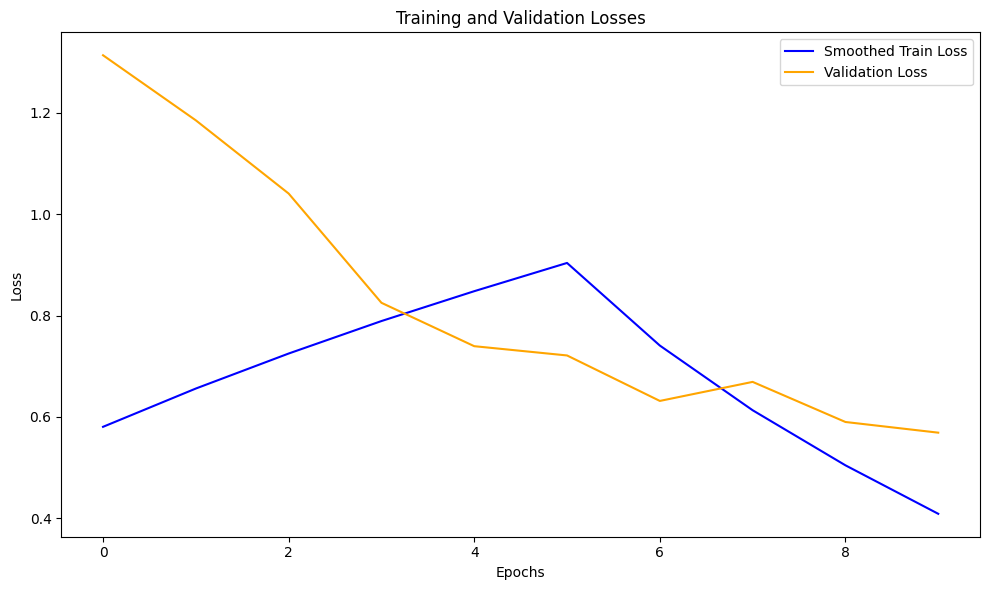

In [64]:
start = time.time()
val_acc = get_acc(model, test_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


**Answer:** The MobileNet paper claims it is 8 to 9 times faster than standard convolution by reducing the computational cost through depthwise separable convolutions. In a standard convolution, the number of floating point operations (FLOPs) is calculated as:

$ H \times W \times C_{in} \times C_{out} \times K^2 $

where $H$ and $W$ are the spatial dimensions, $C_{in}$ and $C_{out}$ are the input and output channels, and $K$ is the kernel size. In contrast, depthwise separable convolutions break the operation into two parts: first, a depthwise convolution (one filter per input channel), requiring:

$ H \times W \times C_{in} \times K^2 $

FLOPs, followed by a pointwise convolution (a 1x1 convolution across all channels), requiring:

$ H \times W \times C_{in} \times C_{out} $

FLOPs. The total FLOPs for depthwise separable convolution are much lower, resulting in 8 to 9 times fewer operations compared to a standard convolution, thus making it significantly faster.


## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [65]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [66]:
# TODO: train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NormalCNN(n_class=10).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

start_time = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    model.train()
    epoch_train_loss = []
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_train_loss.append(loss.item())

        _, predicted = outputs.max(1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    train_losses.append(sum(epoch_train_loss) / len(epoch_train_loss))
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")

    model.eval()
    epoch_val_loss = []
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            epoch_val_loss.append(loss.item())

            _, predicted = outputs.max(1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    val_losses.append(sum(epoch_val_loss) / len(epoch_val_loss))
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

    if val_accuracy > max(val_accuracies):
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("Model saved with accuracy:", val_accuracy * 100)

end_time = time.time()
training_time = end_time - start_time
print(f"Total Training Time: {training_time:.2f} seconds")

print(f"Final Validation Accuracy: {val_accuracies[-1] * 100:.2f}%")

Epoch 1/10
Train Loss: 1.9431, Train Accuracy: 25.99%
Val Loss: 1.8205, Val Accuracy: 32.51%
Epoch 2/10
Train Loss: 1.7117, Train Accuracy: 35.86%
Val Loss: 1.6989, Val Accuracy: 37.91%
Epoch 3/10
Train Loss: 1.5365, Train Accuracy: 43.35%
Val Loss: 1.4017, Val Accuracy: 48.09%
Epoch 4/10
Train Loss: 1.3727, Train Accuracy: 50.18%
Val Loss: 1.3510, Val Accuracy: 50.87%
Epoch 5/10
Train Loss: 1.2015, Train Accuracy: 57.26%
Val Loss: 1.1675, Val Accuracy: 59.18%
Epoch 6/10
Train Loss: 1.0593, Train Accuracy: 62.28%
Val Loss: 1.1260, Val Accuracy: 60.48%
Epoch 7/10
Train Loss: 0.9757, Train Accuracy: 65.50%
Val Loss: 0.9070, Val Accuracy: 68.68%
Epoch 8/10
Train Loss: 0.8947, Train Accuracy: 68.22%
Val Loss: 0.8830, Val Accuracy: 69.90%
Epoch 9/10
Train Loss: 0.8263, Train Accuracy: 70.74%
Val Loss: 0.7890, Val Accuracy: 73.19%
Epoch 10/10
Train Loss: 0.7714, Train Accuracy: 72.96%
Val Loss: 0.7582, Val Accuracy: 73.50%
Total Training Time: 907.78 seconds
Final Validation Accuracy: 73.50%

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.735
Process validation time: 12.8226 s
Convolution Window Size: 10


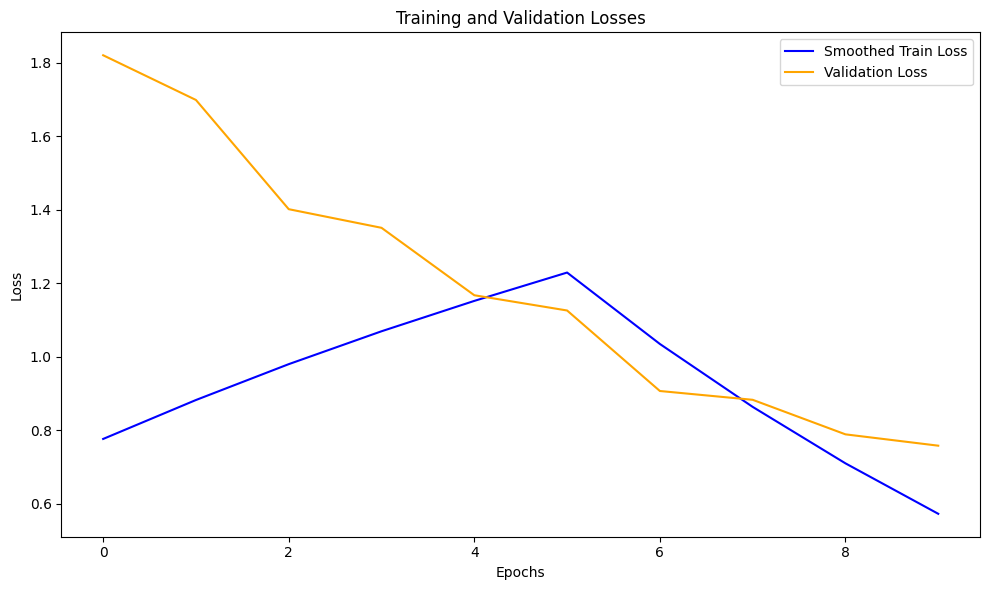

In [67]:
start = time.time()
val_acc = get_acc(model, test_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Compare speed of learning and validating in normal CNN vs MobileNet

**MobileNet v1 significantly outperforms the Normal CNN in both training and validation speed. The reduced training time (by around 4 minutes) and validation time (by about 1.5 seconds) can be attributed to its efficient architecture, which uses depthwise separable convolutions to reduce the number of parameters and floating-point operations. This makes MobileNet not only faster but also more efficient for both training and inference.**

In [68]:
# TODO: compare number of parameters in these two models
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

normal_cnn = NormalCNN(n_class=10)
mobilenet = MobileNet(n_class=10)

normal_cnn_params = count_parameters(normal_cnn)
mobilenet_params = count_parameters(mobilenet)

print(f"Number of parameters in NormalCNN: {normal_cnn_params}")
print(f"Number of parameters in MobileNet: {mobilenet_params}")

Number of parameters in NormalCNN: 28279338
Number of parameters in MobileNet: 3217226


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [87]:
model = MobileNet(n_class=100).to(device)

#Todo:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MobileNet(n_class=100).to(device)

pretrained_dict = torch.load('/kaggle/working/model.pt')

model_dict = model.state_dict()

pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}

model_dict.update(pretrained_dict)

model.load_state_dict(model_dict)

model.fc = nn.Linear(1024, 100).to(device)

<ipython-input-87-a5b10518bf21>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('/kaggle/working/model.pt')


**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [80]:
# Freeze up to the desired layer (e.g., the first 7 layers)
freeze_up_to = 7

layer_count = 0
for name, param in model.named_parameters():
    if 'conv' in name:
        layer_count += 1
    if layer_count <= freeze_up_to:
        param.requires_grad = False
    else:
        param.requires_grad = True

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [81]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)

# Freeze layers up to the 7th convolutional block (or wherever needed)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final layers
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Training loop remains the same
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 50
start_time = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    model.train()
    epoch_train_loss = []
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader100:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_train_loss.append(loss.item())

        _, predicted = outputs.max(1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    train_losses.append(sum(epoch_train_loss) / len(epoch_train_loss))
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")

    model.eval()
    epoch_val_loss = []
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader100:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            epoch_val_loss.append(loss.item())

            _, predicted = outputs.max(1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    val_losses.append(sum(epoch_val_loss) / len(epoch_val_loss))
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

    if val_accuracy > max(val_accuracies):
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("Model saved with accuracy:", val_accuracy * 100)

end_time = time.time()
training_time = end_time - start_time
print(f"Total Training Time: {training_time:.2f} seconds")

print(f"Final Validation Accuracy: {val_accuracies[-1] * 100:.2f}%")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50
Train Loss: 4.4278, Train Accuracy: 4.38%
Val Loss: 4.2393, Val Accuracy: 7.82%
Epoch 2/50
Train Loss: 4.1510, Train Accuracy: 9.87%
Val Loss: 4.0092, Val Accuracy: 11.97%
Epoch 3/50
Train Loss: 3.9762, Train Accuracy: 12.99%
Val Loss: 3.8651, Val Accuracy: 14.39%
Epoch 4/50
Train Loss: 3.8570, Train Accuracy: 14.62%
Val Loss: 3.7506, Val Accuracy: 16.62%
Epoch 5/50
Train Loss: 3.7676, Train Accuracy: 15.91%
Val Loss: 3.6693, Val Accuracy: 17.33%
Epoch 6/50
Train Loss: 3.6972, Train Accuracy: 16.31%
Val Loss: 3.6051, Val Accuracy: 18.30%
Epoch 7/50
Train Loss: 3.6433, Train Accuracy: 17.09%
Val Loss: 3.5526, Val Accuracy: 18.74%
Epoch 8/50
Train Loss: 3.5990, Train Accuracy: 17.32%
Val Loss: 3.5136, Val Accuracy: 18.99%
Epoch 9/50
Train Loss: 3.5610, Train Accuracy: 17.71%
Val Loss: 3.4694, Val Accuracy: 19.52%
Epoch 10/50
Train Loss: 3.5287, Train Accuracy: 18.45%
Val Loss: 3.4403, Val Accuracy: 19.

Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

Files already downloaded and verified


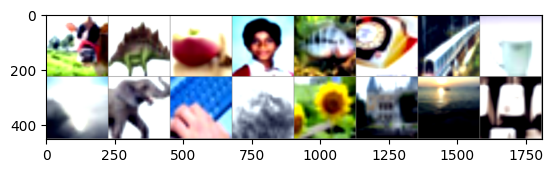

Labels for the first batch of images:  tensor([19, 29,  0, 11,  1, 86, 90, 28, 23, 31, 39, 96, 82, 17, 71, 39])


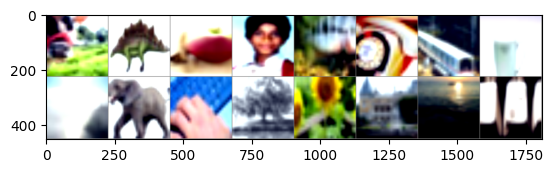

Labels for the augmented batch of images:  tensor([19, 29,  0, 11,  1, 86, 90, 28, 23, 31, 39, 96, 82, 17, 71, 39])


In [110]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=16, shuffle=False, num_workers=2)

data_iter = iter(train_loader100)
images, labels = next(data_iter)


imshow(torchvision.utils.make_grid(images))
print('Labels for the first batch of images: ', labels)


train_loader100_aug = torch.utils.data.DataLoader(
    train_set100, batch_size=16, shuffle=False, num_workers=2)

data_iter_aug = iter(train_loader100_aug)
images_aug, labels_aug = next(data_iter_aug)

imshow(torchvision.utils.make_grid(images_aug))
print('Labels for the augmented batch of images: ', labels_aug)

Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)

**No, the CIFAR-10 and CIFAR-100 datasets do not share any images; they are distinct datasets with separate images and class labels. Both datasets were created from the same source, the 80 million tiny images dataset, but they consist of different subsets. CIFAR-10 contains 60,000 32x32 color images across 10 classes, with 6,000 images per class, while CIFAR-100 includes 60,000 32x32 color images across 100 classes, with 600 images per class. The classes in CIFAR-10 are mutually exclusive and do not overlap with those in CIFAR-100. For example, CIFAR-10 includes classes like "airplane", "automobile", and "truck", whereas CIFAR-100 includes more specific classes such as "pickup truck", "rocket", and "streetcar". Therefore, while both datasets are derived from the same original collection, they do not share images or labels.**

Now train your model using your functions.

In [90]:
epochs = 7
lr = 2e-4
train_losses, val_losses = train(train_loader100, val_loader100, model, epochs, lr)

Epoch 1/7
Train Loss: 2.2806, Val Loss: 1.8439
Model saved.
Epoch 2/7
Train Loss: 2.0056, Val Loss: 1.7071
Model saved.
Epoch 3/7
Train Loss: 1.8158, Val Loss: 1.5960
Model saved.
Epoch 4/7
Train Loss: 1.6760, Val Loss: 1.5237
Model saved.
Epoch 5/7
Train Loss: 1.5513, Val Loss: 1.4477
Model saved.
Epoch 6/7
Train Loss: 1.4482, Val Loss: 1.3941
Model saved.
Epoch 7/7
Train Loss: 1.3658, Val Loss: 1.3636
Model saved.


Get some metrics and plot your losses.

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 0.6113
Process validation time: 11.0497 s
Convolution Window Size: 10


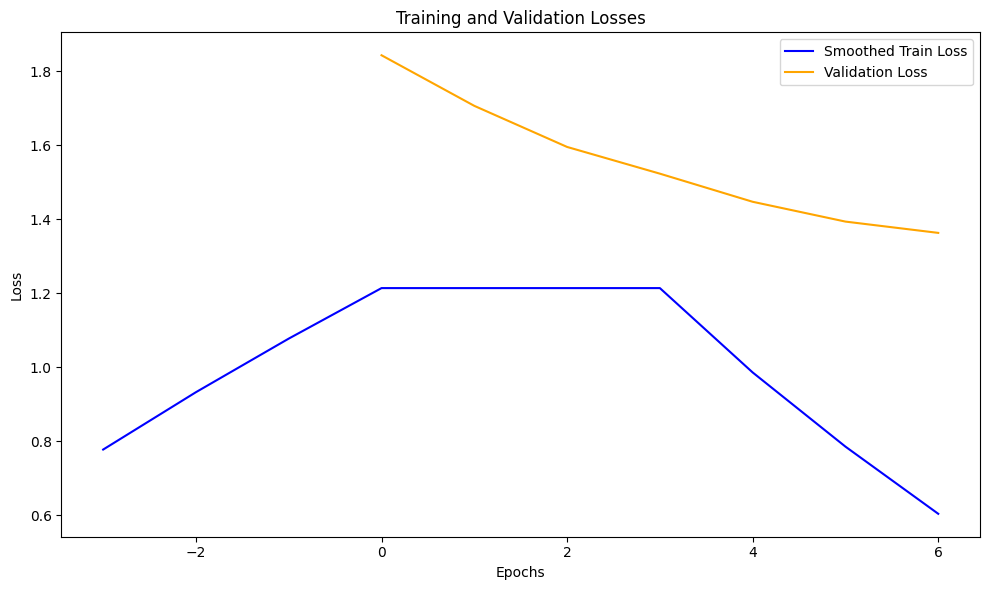

In [91]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

**The ReLU6 (Rectified Linear Unit 6) activation function is a modified version of the standard ReLU (Rectified Linear Unit). It is defined as:** $$ReLU6(x) = min(max(0,x),6)$$

**In deep learning models, especially in mobile and embedded systems, numerical stability is crucial. ReLU6 helps in preventing values from growing too large, which can cause overflow or degrade performance when using lower precision arithmetic, such as in mobile devices or on GPUs with limited resources. By limiting the maximum value to 6, it helps keep the model lightweight, with reduced risk of overfitting to large activations.  In practice, ReLU6 can result in better performance for some tasks compared to standard ReLU, particularly in smaller models.**

In [92]:
def conv_bn(inp, oup, stride):
    # Standard convolution followed by batch normalization and ReLU6 activation
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_1x1_bn(inp, oup):
    # 1x1 pointwise convolution followed by batch normalization and ReLU6 activation
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        self.use_res_connect = self.stride == 1 and inp == oup

        # Expansion layer
        hidden_dim = int(round(inp * expand_ratio))
        
        layers = []
        
        if expand_ratio != 1:
            # 1x1 pointwise convolution to increase channel depth
            layers.append(conv_1x1_bn(inp, hidden_dim))
        
        # Depthwise convolution
        layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False))
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.ReLU6(inplace=True))
        
        # Pointwise-linear convolution to reduce channel depth
        layers.append(conv_1x1_bn(hidden_dim, oup))
        
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [93]:
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super().__init__()
        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = stride == 1 and inp == oup
        
        layers = []
        if expand_ratio != 1:
            # Pointwise convolution (expansion)
            layers.append(nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))
        
        # Depthwise convolution
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            # Pointwise-linear convolution
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):
        super().__init__()

        # Define the configuration for inverted residual blocks
        interverted_residual_setting = [
            [1, 16, 1, 1],  # t, c, n, s
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        input_channel = int(32 * width_multiplier)
        last_channel = int(1280 * width_multiplier) if width_multiplier > 1.0 else 1280

        # First layer: Standard convolution
        self.features = [nn.Sequential(
            nn.Conv2d(3, input_channel, 3, 2, 1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU6(inplace=True)
        )]

        # Add inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(InvertedResidual(input_channel, output_channel, stride, t))
                input_channel = output_channel

        # Last several layers
        self.features.append(nn.Sequential(
            nn.Conv2d(input_channel, last_channel, 1, 1, 0, bias=False),
            nn.BatchNorm2d(last_channel),
            nn.ReLU6(inplace=True)
        ))

        self.features = nn.Sequential(*self.features)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, n_class)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        return x


How did you create linear bottlenecks? How do they help?


**Linear bottlenecks in MobileNetV2 are created by using a narrow (low-dimensional) final pointwise convolution layer in the inverted residual blocks, which projects the higher-dimensional feature space back to a lower dimension without a non-linear activation. This design preserves crucial information by avoiding the distortion caused by non-linear activations on low-dimensional embeddings. Linear bottlenecks help maintain the expressiveness of the model while improving computational efficiency and reducing the number of parameters, making MobileNetV2 suitable for mobile and edge devices.**

Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [95]:
model = MobileNetV2(n_class=10).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader, test_loader, model, epochs, lr)


Epoch 1/10
Train Loss: 1.6355, Val Loss: 1.5274
Model saved.
Epoch 2/10
Train Loss: 1.3080, Val Loss: 1.1615
Model saved.
Epoch 3/10
Train Loss: 1.1272, Val Loss: 1.1124
Model saved.
Epoch 4/10
Train Loss: 0.9955, Val Loss: 1.1089
Model saved.
Epoch 5/10
Train Loss: 0.8972, Val Loss: 0.8940
Model saved.
Epoch 6/10
Train Loss: 0.8167, Val Loss: 0.8264
Model saved.
Epoch 7/10
Train Loss: 0.7657, Val Loss: 0.7502
Model saved.
Epoch 8/10
Train Loss: 0.7168, Val Loss: 0.7370
Model saved.
Epoch 9/10
Train Loss: 0.6682, Val Loss: 0.6944
Model saved.
Epoch 10/10
Train Loss: 0.6433, Val Loss: 0.7025


Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.7671
Process validation time: 11.5181 s
Convolution Window Size: 10


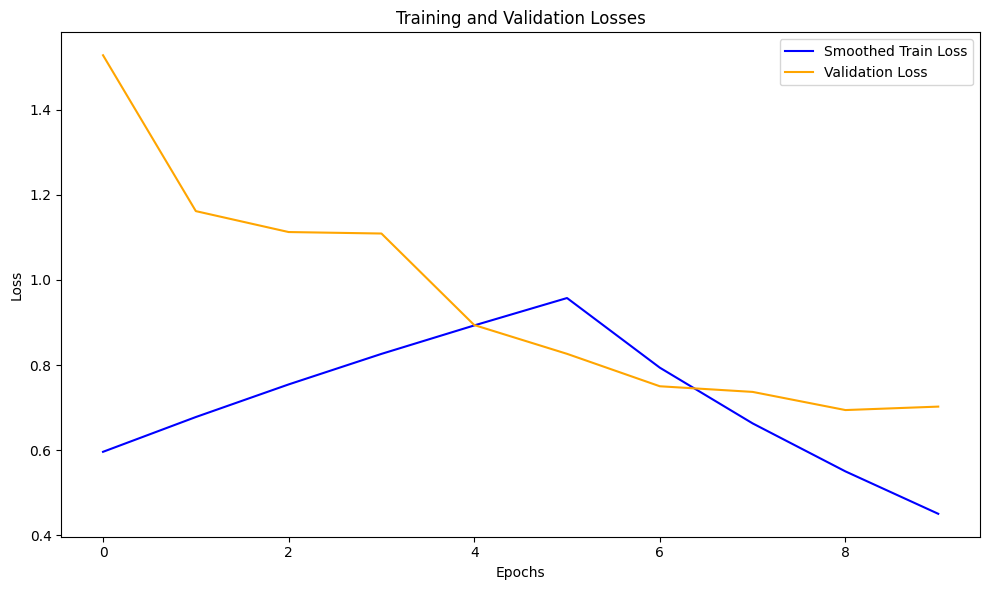

In [97]:
start = time.time()
val_acc = get_acc(model, test_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [98]:
# Function to calculate the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Loop over width multipliers from 0.1 to 1.0 in steps of 0.1
for width_multiplier in [round(0.1 * i, 1) for i in range(1, 11)]:
    model = MobileNetV2(n_class=1000, input_size=224, width_multiplier=width_multiplier)
    num_params = count_parameters(model)
    print(f"With {width_multiplier} width multiplier we got {num_params} parameters")
# TODO


With 0.1 width multiplier we got 1350133 parameters
With 0.2 width multiplier we got 1451238 parameters
With 0.3 width multiplier we got 1586634 parameters
With 0.4 width multiplier we got 1756148 parameters
With 0.5 width multiplier we got 1965448 parameters
With 0.6 width multiplier we got 2199581 parameters
With 0.7 width multiplier we got 2471982 parameters
With 0.8 width multiplier we got 2778586 parameters
With 0.9 width multiplier we got 3119396 parameters
With 1.0 width multiplier we got 3504872 parameters


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [113]:
MNv2_path = './MNv2WMmodel.pt'
# TODO

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))



  0%|          | 0/79 [00:00<?, ?it/s]

Val accuracy = 0.7432
Process validation time: 19.7670 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

**answer**

Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

**answer**

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

**answer**

## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [114]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [115]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))


Val accuracy = 0.0098
Process validation time: 4.0237 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [116]:
class DistillationLoss(nn.Module):
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, student_logits: torch.Tensor, teacher_logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        loss_ce = self.criterion(student_logits, labels)
        teacher_probs = torch.softmax(teacher_logits / self.temperature, dim=1)
        student_probs = torch.softmax(student_logits / self.temperature, dim=1)
        loss_kd = nn.KLDivLoss(reduction='batchmean')(torch.log(student_probs), teacher_probs)
        loss = (1.0 - self.alpha) * loss_ce + self.alpha * loss_kd * (self.temperature ** 2)
        return loss

def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    teacher.to(device).eval()
    student.to(device)
    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        student.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            student_logits = student(inputs)
            teacher_logits = teacher(inputs)
            loss = criterion(student_logits, teacher_logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader)}")
        student_acc = get_acc(student, test_loader)
        print(f"Student Validation Accuracy: {student_acc:.2f}%")

Train it for one epoch to just check if it works.

In [117]:
student = MobileNetV2(n_class=10)

train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)

Epoch [1/1], Loss: 7.5291560665725745
Student Validation Accuracy: 0.01%


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?


**Using a high value of alpha (e.g., 0.9) in the DistillationLoss places more emphasis on the teacher's knowledge, making the student model's output closely align with the teacher's predictions. This can lead to the student model replicating the teacher's behavior more accurately, but it might reduce the student's ability to generalize to new data, as it could overfit to the teacher's soft labels. On the other hand, a low alpha value (e.g., 0.1) prioritizes the student's own predictions (via cross-entropy loss), allowing the model to focus more on the target task and generalize better, but it may not fully capture the teacher's knowledge. A balance between the two is often necessary to achieve good generalization while leveraging the teacher's expertise.**

## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018